# Camelyon_16_training_validation

#### Import modules

In [23]:
import torch
import torchvision
from torch.utils.data import Dataset
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
from torch.nn.utils.rnn import pack_sequence
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import cv2 
import openslide
from openslide import OpenSlide
from openslide import open_slide
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage.color import rgb2hsv
import xml.etree.ElementTree as ET
import numpy as np
import tqdm
import os
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import rasterio as rio

%matplotlib inline

#### Create Dataset Features

In [2]:
datadict={}
Lfilename=[]
Ly=[]
for x in [f"zeus/Data/Camelyon/normal/features/{i+1:03}/feat_normal_{i+1:03}.npy" for i in range(0,110)]:
    Lfilename.append(x)
    Ly.append(0) #normal=0
    
for x in [f"zeus/Data/Camelyon/tumor/features/{i+1:03}/feat_tumor_{i+1:03}.npy" for i in range(0,110)]:
    Lfilename.append(x)
    Ly.append(1) #tumor=1
datadict['filename']=Lfilename
datadict['y']=Ly
dataset= pd.DataFrame(data=datadict)

In [3]:
class CustomImageDataset(Dataset):  #générateur
    def __init__(self, df_filename):
        self.df_filename = df_filename
        self.matrices=[]
        self.labels=[]
        for i in self.df_filename.index:
            #storage of features in RAM
            filename_label = self.df_filename.loc[i]
            filename=filename_label["filename"]
            matrix = torch.load(filename,map_location="cpu").permute((1,0))
            label=filename_label["y"]
            self.matrices.append(matrix)
            self.labels.append(label)    
    def __len__(self):
        return len(self.df_filename)
    def __getitem__(self, idx):
        return self.matrices[idx],self.labels[idx]

dataset_f=CustomImageDataset(dataset)
a=len(dataset_f)
dataset_features={}

dataset_features['train'],dataset_features['val'] = torch.utils.data.random_split(dataset_f, [int(a*0.8), int(a*0.2)]) #80% train, 20% valid
dataset_sizes={}
dataset_sizes['train']=len(dataset_features['train'])
dataset_sizes['val']=len(dataset_features['val'])

#### Create Dataloaders Features

In [4]:
#dataloaders
def collate_fn(batch):    
    data = [item[0] for item in batch]
    
    data =torch.nn.utils.rnn.pad_sequence(data,batch_first=True)
    data = data.permute((0,2,1))
    #print(data.shape)
    targets = torch.Tensor([item[1] for item in batch])
    #print(targets.shape)
    return [data, targets]
#collate_fn can be use to have batch_size>1, to do this add as argument of the dataloader collate_fn=collate_fn
dataloaders_features={'train':torch.utils.data.DataLoader(dataset_features['train'], 
                                batch_size=1, num_workers=0, shuffle=True,pin_memory=True,persistent_workers=False),'val':torch.utils.data.DataLoader(dataset_features['val'], 
                                batch_size=1, num_workers=0, shuffle=True,pin_memory=True,persistent_workers=False)}
next(iter(dataloaders_features['train']))

[tensor([[[2.8071e-03, 3.1574e-03, 0.0000e+00,  ..., 3.4237e-01,
           0.0000e+00, 0.0000e+00],
          [2.0434e-01, 1.0715e-01, 1.3070e-01,  ..., 7.0144e-01,
           1.3176e-01, 2.6184e-01],
          [7.2081e-01, 3.8371e-01, 1.7356e-01,  ..., 2.9928e-01,
           2.1597e-01, 3.3855e-01],
          ...,
          [7.9349e-01, 9.8815e-02, 1.3778e-01,  ..., 6.7545e-01,
           2.4853e-01, 1.9956e-01],
          [3.3725e-01, 8.8816e-03, 4.0663e-03,  ..., 5.3519e-01,
           1.4437e-04, 1.2226e-03],
          [6.2126e-01, 8.5254e-01, 4.2582e-01,  ..., 8.6671e-01,
           4.6801e-01, 3.1480e-01]]]),
 tensor([1])]

#### MIL: Convolutionnal 1-1 Layer+min,max Layer+MLP

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1d=nn.Conv1d(in_channels=2048, out_channels=1, kernel_size=1)
        mlp1 = nn.Linear(10, 200)
        mlp2 = nn.Linear(200, 100)
        mlp3 = nn.Linear(100, 1)
        self.mlp = nn.Sequential(mlp1,nn.Sigmoid(),nn.Dropout(0.25),
                                 mlp2,nn.Sigmoid(),nn.Dropout(0.25),
                                 mlp3)
    def forward(self, x):
        x=self.conv1d(x) #here we have a score for each patch
        x = x.flatten(1)
        min_x,indicemin=(torch.topk(x, 5, dim=1, largest=False,sorted=True))
        max_x,indicemax=(torch.topk(x, 5, dim=1, largest=True,sorted=True))
        output=torch.hstack((min_x,max_x))
        y_pred = self.mlp(output)
        return y_pred



#### Training

Epoch 0/119
----------
train Loss: 0.7220 Acc: 0.4489
val Loss: 0.6931 Acc: 0.4773
Epoch 1/119
----------
train Loss: 0.7000 Acc: 0.5057
val Loss: 0.7025 Acc: 0.3864
Epoch 2/119
----------
train Loss: 0.7074 Acc: 0.4886
val Loss: 0.7056 Acc: 0.3864
Epoch 3/119
----------
train Loss: 0.6931 Acc: 0.5341
val Loss: 0.6962 Acc: 0.3864
Epoch 4/119
----------
train Loss: 0.6949 Acc: 0.4830
val Loss: 0.6954 Acc: 0.3864
Epoch 5/119
----------
train Loss: 0.6949 Acc: 0.5227
val Loss: 0.6967 Acc: 0.3864
Epoch 6/119
----------
train Loss: 0.6922 Acc: 0.5057
val Loss: 0.7181 Acc: 0.3864
Epoch 7/119
----------
train Loss: 0.6945 Acc: 0.5511
val Loss: 0.7145 Acc: 0.3864
Epoch 8/119
----------
train Loss: 0.6892 Acc: 0.5341
val Loss: 0.6884 Acc: 0.6591
Epoch 9/119
----------
train Loss: 0.6890 Acc: 0.5682
val Loss: 0.6815 Acc: 0.5455
Epoch 10/119
----------
train Loss: 0.6804 Acc: 0.5398


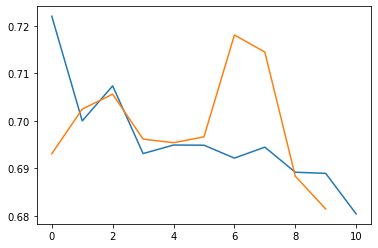

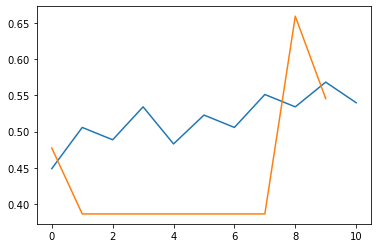

val Loss: 0.6811 Acc: 0.5682
Epoch 11/119
----------
train Loss: 0.6746 Acc: 0.6023
val Loss: 0.6847 Acc: 0.6136
Epoch 12/119
----------
train Loss: 0.6974 Acc: 0.5114
val Loss: 0.6630 Acc: 0.6364
Epoch 13/119
----------
train Loss: 0.6699 Acc: 0.5511
val Loss: 0.6821 Acc: 0.6364
Epoch 14/119
----------
train Loss: 0.6535 Acc: 0.6080
val Loss: 0.6553 Acc: 0.6136
Epoch 15/119
----------
train Loss: 0.6396 Acc: 0.6193
val Loss: 0.6964 Acc: 0.5682
Epoch 16/119
----------
train Loss: 0.6278 Acc: 0.6080
val Loss: 0.6780 Acc: 0.6364
Epoch 17/119
----------
train Loss: 0.6303 Acc: 0.6705
val Loss: 0.7308 Acc: 0.5455
Epoch 18/119
----------
train Loss: 0.6208 Acc: 0.6250
val Loss: 0.6492 Acc: 0.6136
Epoch 19/119
----------
train Loss: 0.6019 Acc: 0.6932
val Loss: 0.6669 Acc: 0.6364
Epoch 20/119
----------
train Loss: 0.6187 Acc: 0.6477


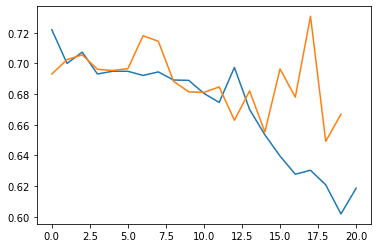

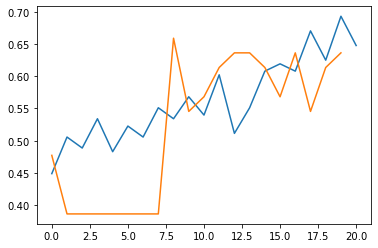

val Loss: 0.6826 Acc: 0.6364
Epoch 21/119
----------
train Loss: 0.5883 Acc: 0.6875
val Loss: 0.6121 Acc: 0.7045
Epoch 22/119
----------
train Loss: 0.5953 Acc: 0.6989
val Loss: 0.5962 Acc: 0.7045
Epoch 23/119
----------
train Loss: 0.5610 Acc: 0.7330
val Loss: 0.5969 Acc: 0.7045
Epoch 24/119
----------
train Loss: 0.5335 Acc: 0.7670
val Loss: 0.5790 Acc: 0.7273
Epoch 25/119
----------
train Loss: 0.5278 Acc: 0.8011
val Loss: 0.5597 Acc: 0.7500
Epoch 26/119
----------
train Loss: 0.5492 Acc: 0.6932
val Loss: 0.5993 Acc: 0.7500
Epoch 27/119
----------
train Loss: 0.5202 Acc: 0.7386
val Loss: 0.5626 Acc: 0.7727
Epoch 28/119
----------
train Loss: 0.4974 Acc: 0.8011
val Loss: 0.5331 Acc: 0.7500
Epoch 29/119
----------
train Loss: 0.4769 Acc: 0.7784
val Loss: 0.5100 Acc: 0.7500
Epoch 30/119
----------
train Loss: 0.4715 Acc: 0.8068


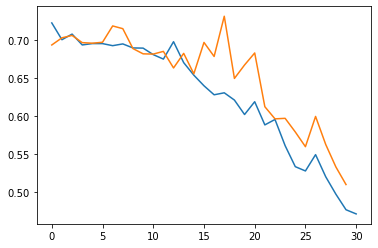

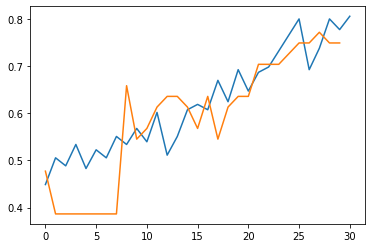

val Loss: 0.5065 Acc: 0.7955
Epoch 31/119
----------
train Loss: 0.4301 Acc: 0.8125
val Loss: 0.4964 Acc: 0.7500
Epoch 32/119
----------
train Loss: 0.4352 Acc: 0.8295
val Loss: 0.4815 Acc: 0.7500
Epoch 33/119
----------
train Loss: 0.4424 Acc: 0.8011
val Loss: 0.5179 Acc: 0.7273
Epoch 34/119
----------
train Loss: 0.3913 Acc: 0.8409
val Loss: 0.5129 Acc: 0.8409
Epoch 35/119
----------
train Loss: 0.3688 Acc: 0.8239
val Loss: 0.6054 Acc: 0.7045
Epoch 36/119
----------
train Loss: 0.4357 Acc: 0.7841
val Loss: 0.4710 Acc: 0.8409
Epoch 37/119
----------
train Loss: 0.4181 Acc: 0.7841
val Loss: 0.4671 Acc: 0.7273
Epoch 38/119
----------
train Loss: 0.3490 Acc: 0.8807
val Loss: 0.4820 Acc: 0.8636
Epoch 39/119
----------
train Loss: 0.3389 Acc: 0.8750
val Loss: 0.4625 Acc: 0.7727
Epoch 40/119
----------
train Loss: 0.3377 Acc: 0.8920


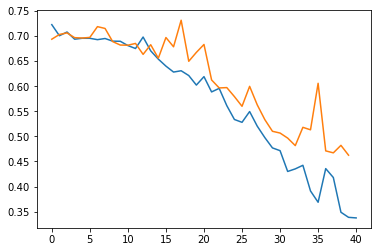

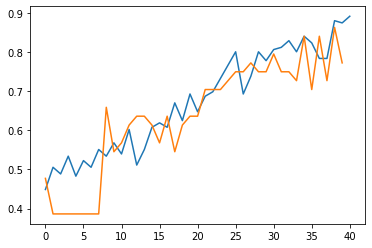

val Loss: 0.4795 Acc: 0.8409
Epoch 41/119
----------
train Loss: 0.3006 Acc: 0.9148
val Loss: 0.4544 Acc: 0.7955
Epoch 42/119
----------
train Loss: 0.3252 Acc: 0.8750
val Loss: 0.5206 Acc: 0.8182
Epoch 43/119
----------
train Loss: 0.2904 Acc: 0.8920
val Loss: 0.4774 Acc: 0.8636
Epoch 44/119
----------
train Loss: 0.3142 Acc: 0.8977
val Loss: 0.4501 Acc: 0.7955
Epoch 45/119
----------
train Loss: 0.3153 Acc: 0.8693
val Loss: 0.4897 Acc: 0.8636
Epoch 46/119
----------
train Loss: 0.3398 Acc: 0.8295
val Loss: 0.4552 Acc: 0.8182
Epoch 47/119
----------
train Loss: 0.2780 Acc: 0.9205
val Loss: 0.5185 Acc: 0.8636
Epoch 48/119
----------
train Loss: 0.2613 Acc: 0.9091
val Loss: 0.4694 Acc: 0.8182
Epoch 49/119
----------
train Loss: 0.2530 Acc: 0.9489
val Loss: 0.4561 Acc: 0.8182
Epoch 50/119
----------
train Loss: 0.2355 Acc: 0.9091


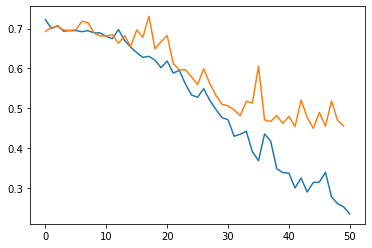

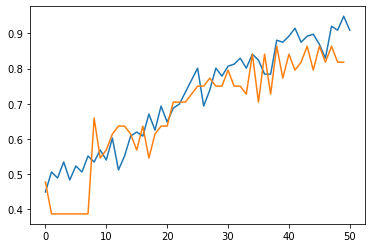

val Loss: 0.4449 Acc: 0.8182
Epoch 51/119
----------
train Loss: 0.2449 Acc: 0.9034
val Loss: 0.5356 Acc: 0.8409
Epoch 52/119
----------
train Loss: 0.2261 Acc: 0.9375
val Loss: 0.4599 Acc: 0.8182
Epoch 53/119
----------
train Loss: 0.2446 Acc: 0.9034
val Loss: 0.5367 Acc: 0.8409
Epoch 54/119
----------
train Loss: 0.2179 Acc: 0.9375
val Loss: 0.4744 Acc: 0.8636
Epoch 55/119
----------
train Loss: 0.2101 Acc: 0.9375
val Loss: 0.5466 Acc: 0.8409
Epoch 56/119
----------
train Loss: 0.1838 Acc: 0.9545
val Loss: 0.4687 Acc: 0.8636
Epoch 57/119
----------
train Loss: 0.2077 Acc: 0.9091
val Loss: 0.5341 Acc: 0.8409
Epoch 58/119
----------
train Loss: 0.1853 Acc: 0.9432
val Loss: 0.4915 Acc: 0.8636
Epoch 59/119
----------
train Loss: 0.1796 Acc: 0.9773
val Loss: 0.4595 Acc: 0.8182
Epoch 60/119
----------
train Loss: 0.1765 Acc: 0.9659


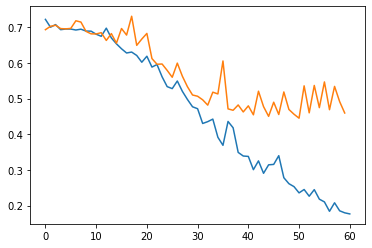

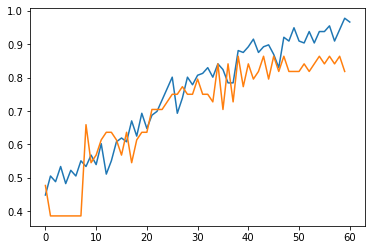

val Loss: 0.5152 Acc: 0.8409
Epoch 61/119
----------
train Loss: 0.1668 Acc: 0.9489
val Loss: 0.4737 Acc: 0.7727
Epoch 62/119
----------
train Loss: 0.2043 Acc: 0.9148
val Loss: 0.5913 Acc: 0.8182
Epoch 63/119
----------
train Loss: 0.1495 Acc: 0.9659
val Loss: 0.5664 Acc: 0.8409
Epoch 73/119
----------
train Loss: 0.1456 Acc: 0.9602
val Loss: 0.4737 Acc: 0.8182
Epoch 74/119
----------
train Loss: 0.1716 Acc: 0.9432
val Loss: 0.5472 Acc: 0.8409
Epoch 75/119
----------
train Loss: 0.1175 Acc: 0.9886
val Loss: 0.5061 Acc: 0.8409
Epoch 76/119
----------
train Loss: 0.1365 Acc: 0.9773
val Loss: 0.5048 Acc: 0.8409
Epoch 77/119
----------
train Loss: 0.1253 Acc: 0.9886
val Loss: 0.5377 Acc: 0.8409
Epoch 78/119
----------
train Loss: 0.1145 Acc: 0.9830
val Loss: 0.5067 Acc: 0.8409
Epoch 79/119
----------
train Loss: 0.1385 Acc: 0.9602
val Loss: 0.6814 Acc: 0.7955
Epoch 80/119
----------
train Loss: 0.1490 Acc: 0.9489


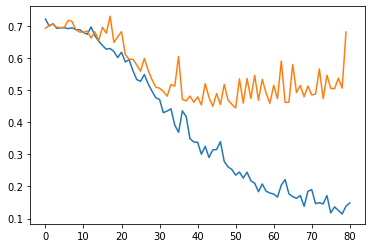

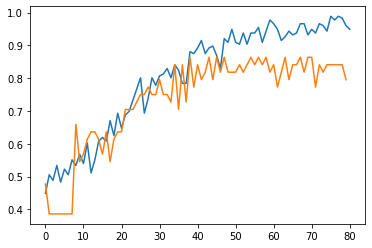

val Loss: 0.5224 Acc: 0.7500
Epoch 81/119
----------
train Loss: 0.1379 Acc: 0.9489
val Loss: 0.5150 Acc: 0.8409
Epoch 82/119
----------
train Loss: 0.1224 Acc: 0.9830
val Loss: 0.5331 Acc: 0.8409
Epoch 83/119
----------
train Loss: 0.1539 Acc: 0.9432
val Loss: 0.5151 Acc: 0.7955
Epoch 84/119
----------
train Loss: 0.1139 Acc: 0.9716
val Loss: 0.5228 Acc: 0.8409
Epoch 85/119
----------
train Loss: 0.1083 Acc: 0.9886
val Loss: 0.5314 Acc: 0.8636
Epoch 86/119
----------
train Loss: 0.1395 Acc: 0.9545
val Loss: 0.5219 Acc: 0.7500
Epoch 87/119
----------
train Loss: 0.1134 Acc: 0.9773
val Loss: 0.5177 Acc: 0.8636
Epoch 88/119
----------
train Loss: 0.1055 Acc: 0.9886
val Loss: 0.5313 Acc: 0.8636
Epoch 89/119
----------
train Loss: 0.1060 Acc: 0.9830
val Loss: 0.5150 Acc: 0.8409
Epoch 90/119
----------
train Loss: 0.1040 Acc: 0.9773


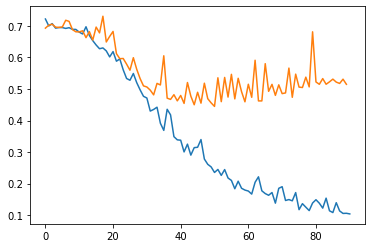

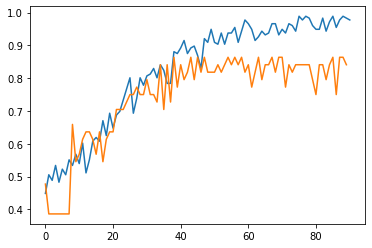

val Loss: 0.5382 Acc: 0.8409
Epoch 91/119
----------
train Loss: 0.0974 Acc: 0.9830
val Loss: 0.5330 Acc: 0.8182
Epoch 92/119
----------
train Loss: 0.0987 Acc: 0.9886
val Loss: 0.6188 Acc: 0.8409
Epoch 93/119
----------
train Loss: 0.0979 Acc: 0.9886
val Loss: 0.6003 Acc: 0.8409
Epoch 94/119
----------
train Loss: 0.1222 Acc: 0.9886
val Loss: 0.5118 Acc: 0.7727
Epoch 95/119
----------
train Loss: 0.0955 Acc: 0.9886
val Loss: 0.5156 Acc: 0.8409
Epoch 96/119
----------
train Loss: 0.0977 Acc: 0.9886
val Loss: 0.5228 Acc: 0.8409
Epoch 97/119
----------
train Loss: 0.0892 Acc: 0.9830
val Loss: 0.6015 Acc: 0.8409
Epoch 98/119
----------
train Loss: 0.1044 Acc: 0.9773
val Loss: 0.5314 Acc: 0.8409
Epoch 99/119
----------
train Loss: 0.1151 Acc: 0.9602
val Loss: 0.5509 Acc: 0.8409
Epoch 100/119
----------
train Loss: 0.0930 Acc: 0.9773


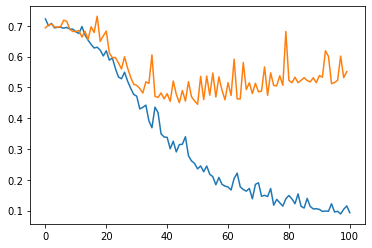

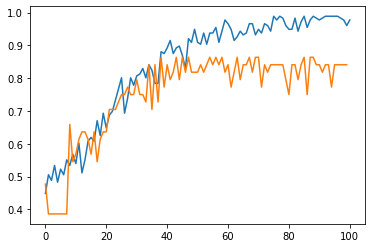

val Loss: 0.5202 Acc: 0.8182
Epoch 101/119
----------
train Loss: 0.1105 Acc: 0.9716
val Loss: 0.5702 Acc: 0.8409
Epoch 102/119
----------
train Loss: 0.0957 Acc: 0.9773
val Loss: 0.5237 Acc: 0.8182
Epoch 103/119
----------
train Loss: 0.0934 Acc: 0.9773
val Loss: 0.5239 Acc: 0.7955
Epoch 104/119
----------
train Loss: 0.0861 Acc: 0.9886
val Loss: 0.5997 Acc: 0.8409
Epoch 105/119
----------
train Loss: 0.0927 Acc: 0.9830
val Loss: 0.5726 Acc: 0.8409
Epoch 106/119
----------
train Loss: 0.0958 Acc: 0.9886
val Loss: 0.5775 Acc: 0.8409
Epoch 107/119
----------
train Loss: 0.0805 Acc: 0.9943
val Loss: 0.5330 Acc: 0.8636
Epoch 108/119
----------
train Loss: 0.1009 Acc: 0.9716
val Loss: 0.5866 Acc: 0.8409
Epoch 109/119
----------
train Loss: 0.1084 Acc: 0.9773
val Loss: 0.5986 Acc: 0.8409
Epoch 110/119
----------
train Loss: 0.0884 Acc: 0.9886


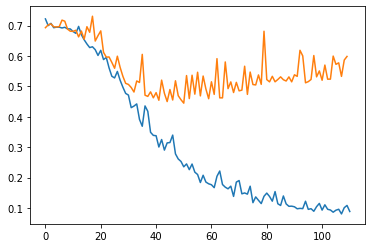

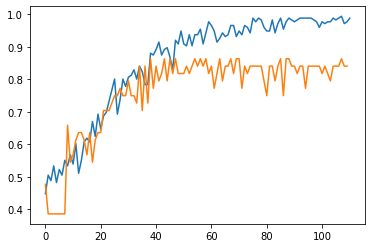

val Loss: 0.5320 Acc: 0.8409
Epoch 111/119
----------
train Loss: 0.0677 Acc: 0.9886
val Loss: 0.5412 Acc: 0.8409
Epoch 112/119
----------
train Loss: 0.0660 Acc: 1.0000
val Loss: 0.5488 Acc: 0.8409
Epoch 113/119
----------
train Loss: 0.0835 Acc: 0.9886
val Loss: 0.5314 Acc: 0.8182
Epoch 114/119
----------
train Loss: 0.0825 Acc: 0.9943
val Loss: 0.5848 Acc: 0.8409
Epoch 115/119
----------
train Loss: 0.0900 Acc: 0.9830
val Loss: 0.5552 Acc: 0.8182
Epoch 116/119
----------
train Loss: 0.1025 Acc: 0.9716
val Loss: 0.5499 Acc: 0.8409
Epoch 117/119
----------
train Loss: 0.1334 Acc: 0.9375
val Loss: 0.5570 Acc: 0.8182
Epoch 118/119
----------
train Loss: 0.1437 Acc: 0.9602
val Loss: 0.6685 Acc: 0.8409
Epoch 119/119
----------
train Loss: 0.0804 Acc: 1.0000
val Loss: 0.6244 Acc: 0.8409
Training complete in 23m 48s
Best val Acc: 0.863636
AUC : 0.8416287878787878
Network(
  (conv1d): Conv1d(2048, 1, kernel_size=(1,), stride=(1,))
  (mlp): Sequential(
    (0): Linear(in_features=10, out_feat

In [6]:
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

losses = {"train":[], "val":[]}
accuracies = {"train":[], "val":[]}
y_true=[]
y_pred=[]

model = Network().to(device)
criterion = nn.BCEWithLogitsLoss()

batch_size = 8

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.parameters(), lr=0.001,  betas=(0.9, 0.999),weight_decay=0.1)  #Adam varies the learning rate automatically
#the weight decay can be modified to reduce overfitting
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    liste_output=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)    
                    outputs = outputs.reshape(-1)
                    preds=torch.sigmoid(outputs)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if ((not i%batch_size) and i != 0) or i==batch_size-1:
                            optimizer.step()
                            # zero the parameter gradients
                            optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.detach()>0.5
                running_corrects += torch.sum(preds == labels.data)
                y_pred.append(preds.cpu().numpy())
                y_true.append(labels.detach().cpu().numpy())
            #if phase == 'train': 
                #scheduler.step()  #we remove the scheduler step for more performance
            if phase=='val' and (not epoch%10) and epoch != 0:
                plt.plot(losses["train"])
                plt.plot(losses["val"])
                plt.show()
                plt.plot(accuracies["train"])
                plt.plot(accuracies["val"])
                plt.show()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc.cpu())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'AUC : {roc_auc_score(y_true,y_pred)}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "zeus/Data/Camelyon/model10.pth") #save the weights of the model, then we can average the scores obtained for each model in order to have more robust scores
    return model
print(train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders_features, num_epochs=120))


In [13]:
plt.plot(losses["train"])
plt.plot(losses["val"])
plt.show()
plt.plot(accuracies["train"])
plt.plot(accuracies["val"])
plt.show()

NameError: name 'losses' is not defined

#### Histogramm and activation map

In [24]:
#dataloaders
def collate_fn(batch):    
    data = [item[0] for item in batch]
    
    data =torch.nn.utils.rnn.pad_sequence(data,batch_first=True)
    data = data.permute((0,2,1))
    #print(data.shape)
    targets = torch.Tensor([item[1] for item in batch])
    #print(targets.shape)
    return [data, targets]

#batch_size=4, num_workers=4,collate_fn=collate_fn
dataloaders_features={'train':torch.utils.data.DataLoader(dataset_features['train'], 
                                batch_size=1, num_workers=0, shuffle=False,pin_memory=True,persistent_workers=False),'val':torch.utils.data.DataLoader(dataset_features['val'], 
                                batch_size=1, num_workers=0, shuffle=False,pin_memory=True,persistent_workers=False)}
#collate_fn=collate_fn,
next(iter(dataloaders_features['train']))

[tensor([[[0.0000, 0.0000, 0.0041,  ..., 0.0038, 0.0207, 0.0181],
          [0.0738, 0.0731, 0.1765,  ..., 0.3060, 0.2237, 0.3137],
          [0.3671, 0.3291, 0.0093,  ..., 0.0790, 0.1451, 0.1080],
          ...,
          [0.6526, 0.4508, 0.1152,  ..., 0.1784, 0.0452, 0.1003],
          [0.0129, 0.0000, 0.0042,  ..., 0.0099, 0.0857, 0.0065],
          [0.8632, 0.5725, 0.1139,  ..., 0.1373, 0.1655, 0.3269]]]),
 tensor([1])]

(array([3.000e+00, 4.000e+00, 4.000e+00, 1.500e+01, 1.600e+01, 2.900e+01,
        4.000e+01, 9.200e+01, 1.680e+02, 3.260e+02, 5.690e+02, 9.460e+02,
        1.343e+03, 1.733e+03, 2.157e+03, 2.379e+03, 2.457e+03, 2.373e+03,
        2.382e+03, 2.263e+03, 2.247e+03, 2.264e+03, 2.416e+03, 2.753e+03,
        3.048e+03, 3.647e+03, 4.257e+03, 5.228e+03, 5.985e+03, 6.592e+03,
        6.965e+03, 7.126e+03, 6.802e+03, 6.616e+03, 6.133e+03, 5.804e+03,
        5.458e+03, 5.390e+03, 5.688e+03, 6.276e+03, 6.853e+03, 7.507e+03,
        8.038e+03, 8.319e+03, 8.336e+03, 7.910e+03, 7.497e+03, 6.603e+03,
        5.947e+03, 5.078e+03, 4.406e+03, 3.833e+03, 3.414e+03, 2.799e+03,
        2.439e+03, 1.996e+03, 1.724e+03, 1.394e+03, 1.234e+03, 1.037e+03,
        8.360e+02, 6.970e+02, 6.150e+02, 5.120e+02, 4.430e+02, 3.150e+02,
        2.720e+02, 2.250e+02, 1.910e+02, 1.380e+02, 1.150e+02, 9.600e+01,
        6.800e+01, 5.800e+01, 5.600e+01, 4.100e+01, 3.200e+01, 2.600e+01,
        1.800e+01, 8.000e+00, 1.300e+0

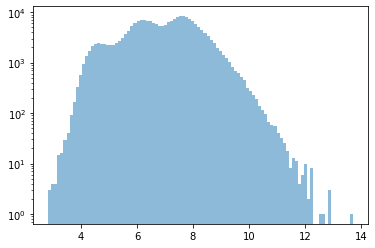

In [25]:
model = Network().to(device)
L=[[],[],[],[],[],[],[],[],[],[]]
L_mean=[]

for inputs, labels in dataloaders_features['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    if labels==1:
        for i in range(1,11):
            model.load_state_dict(torch.load("zeus/Data/Camelyon/model"+str(i)+".pth"))
            outputs = model.conv1d(inputs)
            outputs=torch.flatten(outputs)
            outputs=outputs.cpu().detach().numpy()
            L[i-1].append(outputs)

for k in range(len(L[0])):
    L_mean.append((L[0][k]+L[1][k]+L[2][k]+L[3][k]+L[4][k]+L[5][k]+L[6][k]+L[7][k]+L[8][k]+L[9][k])/10) #average the scores obtained for each model in order to have more robust scores

liste = [item for l in L_mean for item in l]
plt.hist(liste,bins=100,alpha=0.5,log=True)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 8.000e+00, 1.000e+01,
        1.700e+01, 2.400e+01, 3.100e+01, 4.900e+01, 8.100e+01, 1.040e+02,
        1.670e+02, 2.330e+02, 3.090e+02, 4.200e+02, 5.190e+02, 6.270e+02,
        7.250e+02, 7.630e+02, 7.680e+02, 7.550e+02, 7.040e+02, 6.550e+02,
        6.640e+02, 7.730e+02, 8.280e+02, 9.820e+02, 1.260e+03, 1.623e+03,
        2.239e+03, 2.908e+03, 3.964e+03, 4.925e+03, 5.831e+03, 6.859e+03,
        7.369e+03, 7.718e+03, 7.736e+03, 7.325e+03, 6.998e+03, 6.395e+03,
        5.777e+03, 5.145e+03, 4.548e+03, 3.969e+03, 3.519e+03, 2.997e+03,
        2.669e+03, 2.456e+03, 2.090e+03, 1.821e+03, 1.587e+03, 1.367e+03,
        1.208e+03, 1.116e+03, 9.400e+02, 8.320e+02, 7.210e+02, 5.660e+02,
        5.450e+02, 4.140e+02, 3.840e+02, 3.320e+02, 2.590e+02, 2.150e+02,
        2.150e+02, 1.770e+02, 1.170e+02, 1.230e+02, 9.600e+01, 7.300e+01,
        6.000e+01, 6.500e+01, 4.300e+0

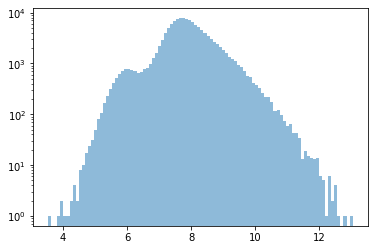

In [26]:
model = Network().to(device)
L=[[],[],[],[],[],[],[],[],[],[]]
L_mean=[]

for inputs, labels in dataloaders_features['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    if labels==0:
        for i in range(1,11):
            model.load_state_dict(torch.load("zeus/Data/Camelyon/model"+str(i)+".pth"))
            outputs = model.conv1d(inputs)
            outputs=torch.flatten(outputs)
            outputs=outputs.cpu().detach().numpy()
            L[i-1].append(outputs)
for k in range(len(L[0])):
    L_mean.append((L[0][k]+L[1][k]+L[2][k]+L[3][k]+L[4][k]+L[5][k]+L[6][k]+L[7][k]+L[8][k]+L[9][k])/10)
liste = [item for l in L_mean for item in l]
plt.hist(liste,bins=100,alpha=0.5,log=True)

We have a threshold of 3 or 4, we assume that the tumor patches are below this threshold.

In [27]:

model = Network().to(device)

def pixel_scores(img,L_patch,treshold,scores,patch_dict,patch_scores_path):
    fig=plt.figure(figsize=(30,30))
    rows = 30
    columns = 30
    i=1
    for k in range(len(scores)):
        if scores[k]<treshold:
            coord=tuple(patch_dict[k][1]['corner'])
            size=patch_dict[k][1]['size']
            coord2 = ((coord[0]+size)//100, (coord[1]+size)//100 )
            coord1  = (coord[0] //100, coord[1]//100) 
            img = cv2.rectangle(img,coord1, coord2, (255, 0, 0), 1 )
            image = mpimg.imread(L_patch[k])
            a=fig.add_subplot(rows,columns, i) 
            a.imshow(image) 
            plt.axis('off') 
            plt.title(str(k))
            i+=1
    Image.fromarray(img).save(patch_scores_path)
          

None


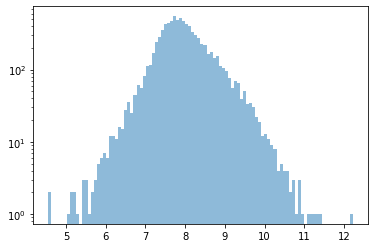

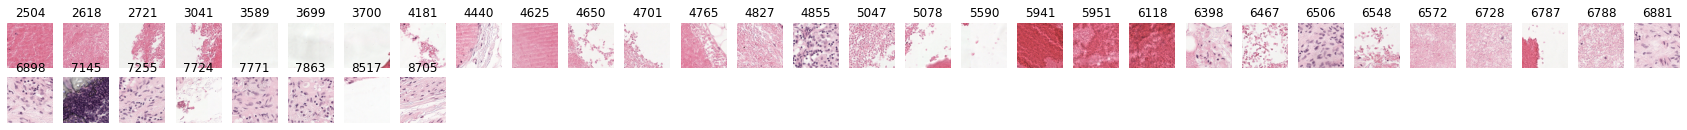

In [29]:
def visualize_predictions(i,treshold):
    a=torch.load(f"zeus/Data/Camelyon/tumor/features/{i:03}/feat_tumor_{i:03}.npy",map_location="cpu").permute((1,0))
    a=a.to(device)
    image_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/tumor_{i:03}.tif"
    test = rio.open(image_path)
    img=OpenSlide(image_path)
    thumbnail=img.get_thumbnail((test.width//100,test.height//100))
    thumbnail=np.array(thumbnail)
    thumbnail= thumbnail.astype(np.uint8)
    img_array = np.array(thumbnail)
    patch_scores_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/patch_scores_patches.jpg"
    patch_dict=np.load(f"zeus/Data/Camelyon/tumor/images/{i:03}/patch_dict.npy",allow_pickle=True)
    real_scores_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/real_scores_patches.jpg"
    L=[[],[],[],[],[],[],[],[],[],[]]
    L_mean=[]
    for x in range(1,11):
        model.load_state_dict(torch.load("zeus/Data/Camelyon/model"+str(x)+".pth"))
        outputs = model.conv1d(a)
        outputs=torch.flatten(outputs)
        outputs=outputs.cpu().detach().numpy()
        size=len(outputs)
        L[x-1].append(outputs)
    for k in range(len(L[0])):
        L_mean.append((L[0][k]+L[1][k]+L[2][k]+L[3][k]+L[4][k]+L[5][k]+L[6][k]+L[7][k]+L[8][k]+L[9][k])/10)
    L_mean[0].tolist()
    liste = [item for l in L_mean for item in l]
    plt.hist(liste,bins=100,alpha=0.5,log=True)
    size=len(L_mean[0])
    L_patch=[]
    for j in range(size):
        L_patch.append(f"zeus/Data/Camelyon/tumor/images/{i:03}/patch/tumor_{i:03}_patch"+str(j)+'.png')
    L_patch.sort()
    for w in range(len(patch_dict)):
        patch_dict[w][0]=str(patch_dict[w][0])
    a=sorted(patch_dict, key = itemgetter(0))
    for z in range(len(a)):
        a[z][0]=int(a[z][0])
    return pixel_scores(img_array,L_patch,treshold,L_mean[0],a,patch_scores_path)
print(visualize_predictions(10,6))
    

#### Comparaison with the real segmentation

In [220]:
def svisualize_segmentation(i):
    tree = ET.parse(f'zeus/Data/Camelyon/tumor/images/{i:03}/tumor_{i:03}.xml')
    root = tree.getroot()
    coord_dict={}
    list_coord=[]
    index=1
    for coord in root.findall('Annotations/Annotation/Coordinates/Coordinate'):
        X= coord.attrib['X']
        Y=coord.attrib['Y']
        coord_dict[index]=[float(X),float(Y)]
        list_coord.append((float(X),float(Y)))
        index+=1
    image_path=f"zeus/Data/Camelyon/tumor/images/{i:03}/tumor_{i:03}.tif"
    img=OpenSlide(image_path)
    test = rio.open(image_path)
    thumbnail=img.get_thumbnail((test.width//100,test.height//100))
    thumbnail=np.array(thumbnail)
    thumbnail= thumbnail.astype(np.uint8)
    img_array = np.array(thumbnail)
    for x in range(len(coord_dict)):
        size=10
        coord2 = (int((coord_dict[x+1][0]+size)//100), int((coord_dict[x+1][1]+size)//100) )
        coord1  = (int(coord_dict[x+1][0] //100),int( coord_dict[x+1][1]//100))
        img = cv2.rectangle(img_array,coord1, coord2, (255, 0, 0), 1)
    Image.fromarray(img).save(f'zeus/Data/Camelyon/tumor/images/{i:03}/segmentation.png')